In [7]:
from networkie.gen.Custom import LoadFromFile
c=LoadFromFile()
g=c.from_in_class_network("dataset/In-class_network.txt")

from networkie.utils.Measures import Node
d= Node()
d.degree_dist(g)

C:\Users\admin\Desktop\networkie\networkie\gen\Custom.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  a[i] =[int(a[i])]
C:\Users\admin\Desktop\networkie\networkie\gen\Custom.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  a[i] = a[i].split(",")


[1,
 1,
 5,
 3,
 6,
 4,
 5,
 6,
 2,
 9,
 2,
 2,
 5,
 5,
 1,
 4,
 1,
 3,
 5,
 4,
 4,
 1,
 1,
 1,
 6,
 5,
 0,
 2,
 1,
 1,
 2,
 3,
 1,
 5,
 1,
 4,
 1,
 4,
 5,
 4,
 1,
 4,
 1,
 3,
 2,
 2,
 2,
 4,
 3,
 5,
 1,
 4,
 1,
 3,
 1,
 1,
 4,
 1,
 2,
 1,
 1,
 2,
 2,
 3,
 4,
 2,
 4,
 4,
 3,
 5,
 8,
 3,
 2,
 3,
 0]

c:\python35\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\python35\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


node: 75
edges: 109
average degree: 2.9066666666666667
average path lengt: 1.7254054054054053
nG: 45
e/emax: 0.03927927927927928


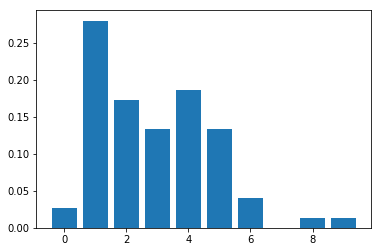

number of triangles: 52.0


In [14]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

#3
#3(a)
df = pd.read_csv('In-class_network.txt',delimiter = '\t') #open the file
g = nx.Graph()
id_1=df["ID"]
a=df['IDs-of-acquaintances']

#3.(b)(1)(2)(3)
for i in range(len(a)): #Change data from string to int
    if "," in a[i]:        
        a[i] = a[i].split(",")
        for j in range(len(a[i])):
            a[i][j]=int(a[i][j])
            
    elif a[i]==" ":
        continue
        
    else:
        a[i] =[int(a[i])]

    g.add_nodes_from(a[i])
    g.add_nodes_from(id_1)
    for j in range(len(a[i])): #combine ID and acquaintances
        g.add_edge(int(id_1[i]),a[i][j])

print("node:",len(g.nodes())) 
print("edges:",len(g.edges())) 
print("average degree:",len(g.edges())*2/len(g.nodes()))

#3.(b)(4)
p,n=0,0       #Add up the minimum distances for various combinations
for i in range(len(g.nodes())):
    s=list(range(len(g.nodes())))[i+1:]
    for j in s:
        n+=1
        if nx.has_path(g,i,j):
            p+=(len(nx.shortest_path(g,source=i,target=j))-1)
mean_length=p/n #compute average
print("average path lengt:",mean_length)

#3.(b)(5)
max=0        
for i in list(nx.connected_components(g)):
    if len(i)>max: 
        max=len(i)
print("nG:",max) 

#3.(c)
e_max=75*74/2
print("e/emax:",len(g.edges())/e_max) 

#3(d)方法一
l=[]   #Draw the 75 nodes degree distribution
for i in range(len(g.nodes())):
    l.append(g.degree(i))

plt.bar(g.nodes(),l)
plt.xlabel("ID")
plt.ylabel("Degree")

#3(d)方法二
degree_d1=[]  #Plot the probability of each degree of freedom
count_d1=[]
for i in list(g.nodes()):
    degree_d1.append(g.degree(i))
degree_d1=sorted(degree_d1)
for i in list(set(degree_d1)):
    count_d1.append(degree_d1.count(i)/len(degree_d1))
    
plt.bar(list(set(degree_d1)),count_d1)
plt.show()


#3.(e)
tri = nx.triangles(g)
# print('Show number of triangles each node contains in: ', tri)
print("number of triangles:",sum(tri.values())/3)